In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import math

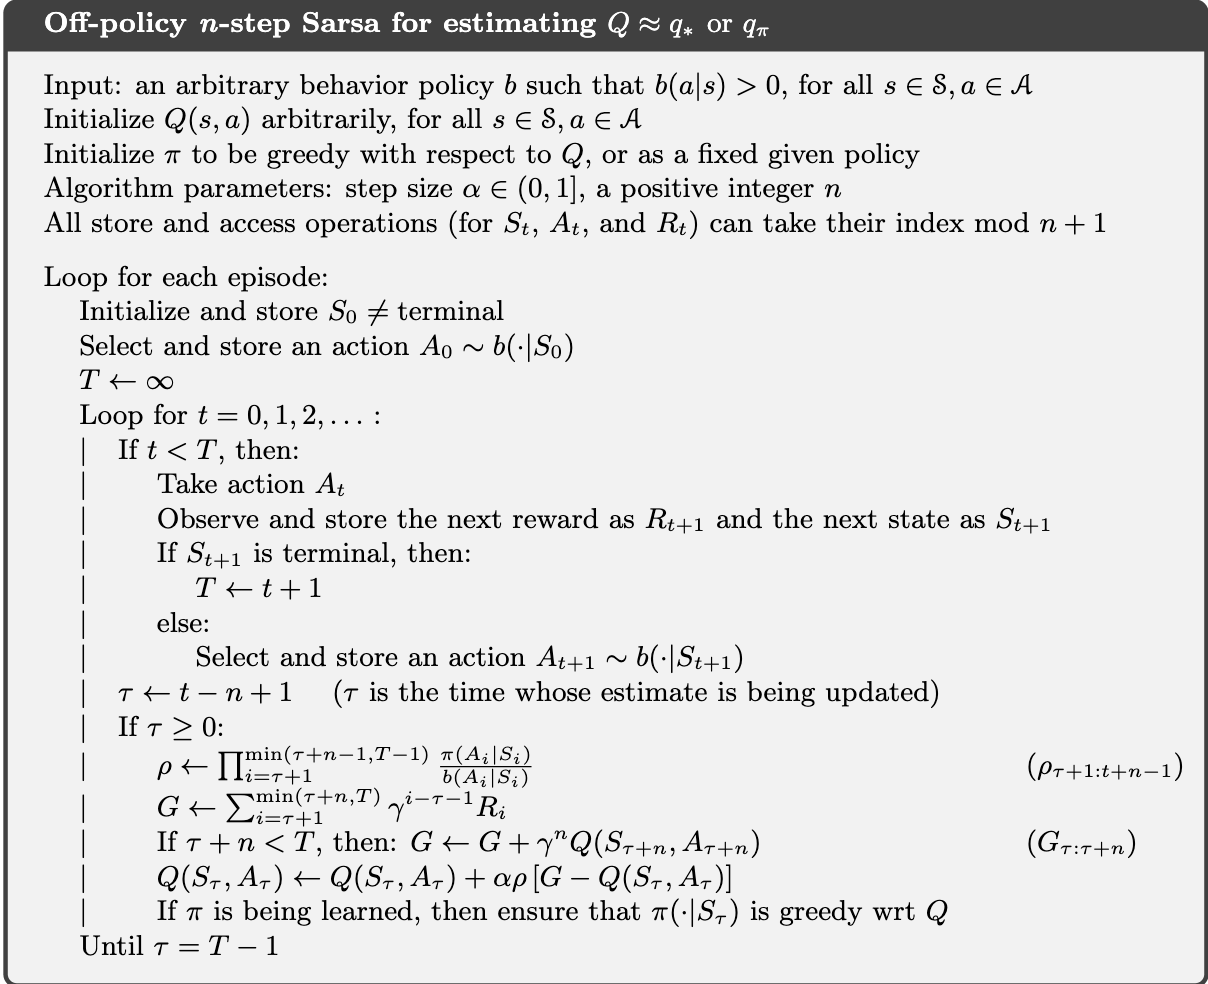

In [ ]:
def off_policy_n_step_Sarsa(env, b, n, step_size=0.5, discount_factor=0.99, episodes=10000):
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    target_policy = np.zeros((nS, nA))
    for s in range(nS):
        target_policy[s].fill(0.0)
        target_policy[s][np.argmax(Q[s])] = 1.0
    for i in range(episodes):
        state, _ = env.reset()
        T = math.inf
        t = 0

        rewards = [0.0] * (n + 1)
        states = [0] * (n + 1)
        actions = [0] * (n + 1)
        states[0] = state
        action = np.random.choice(nA, p=b[state])
        while(True):
            if t < T:
                actions[t % (n + 1)] = action

                s_next, reward, term, trun, _ = env.step(action)
                states[(t + 1) % (n + 1)] = s_next #store S(t+1)
                rewards[(t + 1) % (n + 1)] = reward #store R(t+1)
                state = s_next
                if term or trun:
                    T = t + 1
                else:
                    action = np.random.choice(nA, p=b[state])
                    actions[(t + 1) % (n + 1)] = action #store A(t+1)
            tau = t - n + 1
            if tau >= 0:
                row_upper = min(tau + n - 1, T - 1)
                row = 1.0
                for k in range(tau + 1, row_upper + 1):
                    row *= (target_policy[states[k % (n + 1)]][actions[k % (n + 1)]])/(b[states[k % (n + 1)]][actions[k % (n + 1)]])
                G_upper = min(tau + n, T) #this is for if the episode terminates in the middle of the sliding window
                G = 0.0
                for k in range(tau + 1, G_upper + 1): #include the last one
                    G += (discount_factor ** (k - tau - 1)) * rewards[k % (n + 1)]
                if (tau + n) < T:
                    G += (discount_factor ** n) * Q[states[(tau + n) % (n + 1)]][actions[(tau + n) % (n + 1)]]
                Q[states[tau % (n + 1)]][actions[tau % (n + 1)]] += row * step_size * (G - Q[states[tau % (n + 1)]][actions[tau % (n + 1)]])
                s_tau = states[tau % (n + 1)]
                target_policy[s_tau].fill(0.0)
                target_policy[s_tau][np.argmax(Q[s_tau])] = 1.0


            t += 1
            if tau == (T - 1):
                break
    return target_policy, Q

